<a href="https://colab.research.google.com/github/mocedon/CVHW/blob/master/Graph_SSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connect to drive to save work
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/EE049064

!git clone https://github.com/BIueMan/ImageSelfClustering
!git pull
%cd ImageSelfClustering

Mounted at /content/gdrive
/content/gdrive/MyDrive/EE049064
fatal: destination path 'ImageSelfClustering' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/content/gdrive/MyDrive/EE049064/ImageSelfClustering


In [2]:
from funcrions.graph_laplacian import weight, weight_ssl

In [18]:
import cv2
im = cv2.cvtColor(cv2.imread('./images/Amanita_muscaria_test.jpeg'), cv2.COLOR_BGR2RGB) / 255

In [2]:
import cv2
im = cv2.cvtColor(cv2.imread('./images/car.jpeg'), cv2.COLOR_BGR2RGB) / 255

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
import time
from google.colab.patches import cv2_imshow
import os

from sklearn.cluster import SpectralClustering

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.utils.data import TensorDataset, DataLoader
import torchvision

# Auxilary

In [2]:
def toy_image(imgSz):
  R_ = np.array([255,0,0]) / 255
  G_ = np.array([0,255,0]) / 255
  B_ = np.array([0,0,255]) / 255

  v1 = [R_, G_, B_, R_ + G_]
  v2 = [1, 2, 3, 4]

  img = np.zeros((*imgSz ,3),dtype=np.float32)
  ref = np.zeros(imgSz)

  arr = [[img, *imgSz, v1], [ref, *imgSz, v2]]
  for [im, H, W, v] in arr:
    x1, y1, r1 = W // 6 , H // 4, W // 8
    x2, y2, r2 = 3*W // 4 , H // 4, H //4
    x3, y3, r3 = W // 4 , 3*H // 4, W // 5
    x4, y4, r4 = 3*W // 4 , 3*H // 4, H // 6

    X,Y = np.meshgrid(range(W), range(H))

    im[(X-x1)**2 + (Y-y1)**2 <= r1**2] = v[0]
    im[(X-x2)**2 + (Y-y2)**2 <= r2**2] = v[1]
    im[(X-x3)**2 + (Y-y3)**2 <= r3**2] = v[2]
    im[(X-x4)**2 + (Y-y4)**2 <= r4**2] = v[3]

  return img, ref

In [6]:
def nullFunc(*arg):
  return None

In [7]:
def save_img(img, imgFn):
  return None

def save_mtx(smp, mtxFn):
  return None


In [8]:
def load_img(imgFn):
  return None

def load_mtx(mtxFn):
  return None


In [9]:
def show_image(image, grid=None):
  ext = 0, image.shape[1], 0, image.shape[0]
  plt.imshow(image, extent=ext)
  if grid is not None:
    
    plt.imshow(grid, alpha=0.5, extent=ext, interpolation='nearest')


# Preprocess functions

In [4]:
class splitPatches:
  def __init__(self, sz, st):
    self.hig = sz[0]
    self.wid = sz[1]
    self.st = st
  
  def __call__(self, img, ref):
    H, W = img.shape[:2]
    h = (H - (self.hig - self.st)) // self.st
    w = (W - (self.wid - self.st)) // self.st
    d = 3 if len(img.shape) == 3 else 1
    imgSplit = np.zeros((h,w, self.hig, self.wid, d), dtype=np.float32)
    refSplit = np.zeros((h,w), dtype=np.int32)
    for i in range(h):
      for j in range(w):
        imgSplit[i, j] = img[i*self.st : i*self.st + self.hig, j*self.st : j*self.st + self.wid]
        refSplit[i, j] = ref[i*self.st + (self.hig // 2), j*self.st + (self.wid //2)]
    return np.squeeze(imgSplit) , refSplit
        



class colorConvert:
  def __init__(self, scheme=cv2.COLOR_RGB2GRAY):
    self.scheme = scheme

  def __call__(self, patches):
    sz = patches.shape[:-1] if self.scheme == cv2.COLOR_RGB2GRAY else patches.shape
    pt = np.zeros(sz, dtype=np.float32)
    for p in range(patches.shape[0]):
      pt[p] = cv2.cvtColor(patches[p], self.scheme)
    return pt
    

In [4]:
class maskLabels:
  def __init__(self, p=0.05):
    self.p = p
  def __call__(self, lables, mask=None):
    if mask is None:
      mask = np.random.binomial(1, self.p, lables.shape)
    smp = np.zeros(lables.shape)
    smp[mask == 1] = lables[mask == 1]
    return smp



In [ ]:
img, ref = toy_image([400, 600])
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(maskLabels()(ref))
plt.subplot(133)
plt.imshow(ref)

In [ ]:
splt = splitPatches((28,28),28)
print(img.shape)
ptc, lbl = splt(img, ref)
ptcG = colorConvert()(ptc)
print("patches shape", ptc.shape)
print("labels shape", lbl.shape)
print(lbl)
plt.figure(figsize=(15,15))
for i in range(6):
  
  plt.subplot(2,3,(i+1)) 
  plt.imshow(ptc[i])
  plt.axis('off')

np.save('./patches_toy', ptc)
np.save('./toy', img)

In [5]:
def histogram(patches, bins=32):
  pt_sz = patches.shape[0]
  patch = patches.reshape(pt_sz, -1)
  hist = np.zeros((pt_sz, bins))
  min = np.min(patch)
  max = np.max(patch)
  patch = (patch - min) / (max - min)
  patch = (255 * patch) // (256/bins)
  for i, p in enumerate(patch):
    for pix in p:
      hist[i][int(pix)] += 1
    
  return hist


## Auto encoder

In [6]:
class AE_default(nn.Module):
    
    def __init__(self, input_dim=28*28, hidden_dim=256, latent_dim=10):
        super(AE_default, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # define the encoder
        self.encoder = nn.Sequential(nn.Linear(self.input_dim, self.hidden_dim),
                                     nn.ReLU(), nn.Linear(self.hidden_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.latent_dim))
        
        # define decoder
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.input_dim),
                                     nn.Sigmoid())
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    def latent(self, x):
        return self.encoder(x)

In [7]:
class AEtrainer:

  def __init__(self, hp):
    self.AE = hp['AE']
    self.hp = hp

    self.crt = nn.BCELoss()
    self.opt = torch.optim.Adam(self.AE.parameters(), lr = hp['lr'])

    self.dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  
  def train(self, patches):
    patch = torch.from_numpy(patches)
    patch = patch.view(patches.shape[0], -1)
    ds = TensorDataset(patch)
    ld = DataLoader(ds, self.hp['batch_size'], shuffle=True)
    for ep in range(self.hp['epochs']):
      for [bt] in ld:
        bt.to(self.dev)
        out = self.AE(bt)
        loss = self.crt(out, bt)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
      if (ep % 20 == 19):
        print("epoch {:3d}/{:3d} - Loss {:.4f}".format(ep, self.hp['epochs'], loss.item()))

  def latent(self, patches):
    patch = torch.from_numpy(patches)
    patch = patch.view(patches.shape[0], -1)
    return self.AE.latent(patch)

  def __call__(self, patches):
    self.train(patches)
    return self.latent(patches)

  def rec(self, patches):
    patch = torch.from_numpy(patches)
    patch = patch.view(patches.shape[0], -1)
    return self.AE(patch)

  def show(self, patches):
    patch = torch.from_numpy(patches)
    sz = patch.size()
    patch = patch.view(patches.shape[0], -1)
    rec =self.AE(patch)

    plt.subplot(211)
    plt.imshow(patches[0])
    plt.subplot(212)

    rec = torch.reshape(rec, sz).detach().numpy()
    plt.imshow(rec[0])


# Weight functions

In [18]:
def L2dist(p1,p2):
  return np.sum((p1 - p2) ** 2) / (p1.shape[0] ** 2)


def wL2dist(patches, classes):
  p = patches.shape[0]
  w = np.zeros((p,p))
  for i in range(p):
    for j in range(i, p):
      w[i,j] = L2dist(patches[i], patches[j])
      w[j,i] = w[i,j]
  return w

def SSL(w,s):
  p = w.shape[0]
  m = np.max(w)
  for i in range(p):
    for j in range(p):
      v = w[i,j] if ((g[i,j] == 0)) else m 


In [19]:
def SSL_weights(pt, lb):
  w = weight(pt)
  w = weight_ssl(pt, w, lb)
  return w

# Solve functions

In [20]:
def SSL_solve(w):
  return SpectralClustering(5).fit_predict(w)

# Compare functions

In [21]:
def Compare(res, ref):
  res = res.reshape((ref.shape[0], ref.shape[1]))
  
  plt.figure(figsize=(15,15))
  
  plt.subplot(2,1,1) 
  plt.imshow(ref)
  plt.title('ref')
  plt.axis('off')

  
  plt.subplot(2,1,2) 
  plt.imshow(res)
  plt.title('res')
  plt.axis('off')

# Configuration class

In [8]:
def defaultDict(ptz=32):
  dct = {'name': 'imageDir', 
         'patchSize': (ptz,ptz),
         'patchStep': ptz,
         # AE model
         'AE': AE_default(3*ptz*ptz, ptz , ptz // 4),
         'lr': 0.001,
         'epochs' : 100,
         'batch_size': 128}
  return dct

In [23]:
class configuration:
  def __init__(self, dct=defaultDict()):
    self.dct = dct

    dn = os.path.join(os.getcwd(), dct['name'])
    patchSize = dct['patchSize']
    patchStep = dct['patchStep']


    self.imgFn = os.path.join(dn, 'image')
    self.smpFn = os.path.join(dn, 'sample')
    self.refFn = os.path.join(dn, 'ref')
    self.ptcFn = os.path.join(dn, 'patches', 'pt')
    self.aenFn = os.path.join(dn, 'patches', 'ae')
    self.wgtFn = os.path.join(dn, 'weights')
    self.resFn = os.path.join(dn, 'result')
    self.errFn = os.path.join(dn, 'err')

    self.splitFunc = dct.get("splitFunc", splitPatches(patchSize, patchStep))
    self.maskFunc = dct.get("maskFunc", maskLabels())
    self.preprocFunc = dct.get("preprocFunc", colorConvert())
    self.weightFunc = dct.get("weightFunc", SSL_weights)
    self.solveFunc = dct.get("solveFunc", SSL_solve)
    self.compareFunc = dct.get("compareFunc", nullFunc)

  def __getitem__(self, item):
    return self.dct[item]

  def __setitem__(self, item, val):
    self.dct[item] = val

# Image class

In [24]:
class Image:
  def __init__(self, img=None, ref=None, config=configuration()):
    self.config = config

    self.patches = None
    self.weight = None
    self.result = None
    self.error = None

    self.load(config)

    if img is not None:
      self.image = img
    if ref is not None:
      self.ref = ref

    if self.image is None:
      print("No input image given")

  def Preprocess(self):
    imgSplit, refSplit = self.splitFunc(self.image, self.ref)
    self.patches = self.preprocFunc(imgSplit)
    self.labels = self.maskFunc(refSplit)

  def CalcWeights(self):
    if self.patches is None:
      print("Patches don't exist")
    else:
      print("weight calc")
      self.weight = self.weightFunc(self.patches, self.labels)

  def Solve(self):
    if self.weight is None:
      print("Weights don't exist")
    else:
      self.result = self.solveFunc(self.weight)

  def Compare(self):
    if self.result is None:
      print("Results don't exist")
    else:
      if self.ref is None:
        print("There is no reference")
      else:
        self.error = self.compareFunc(self.result, self.ref)
        
  def __call__(self):
    self.Preprocess()
    self.CalcWeights()
    self.Solve()
    self.Compare()
    self.save()
  
  def load(self, config):
    self.image = load_img(self.config.imgFn)
    self.ref = load_mtx(self.config.refFn)
    self.patches = load_img(self.config.ptcFn)
    self.weight = load_mtx(self.config.wgtFn)
    self.result = load_mtx(self.config.resFn)

    self.splitFunc = self.config.splitFunc
    self.maskFunc = self.config.maskFunc
    self.preprocFunc = self.config.preprocFunc
    self.weightFunc = self.config.weightFunc
    self.solveFunc = self.config.solveFunc
    self.compareFunc = self.config.compareFunc

  def save(self):
    save_img(self.image, self.config.imgFn)
    save_mtx(self.ref, self.config.refFn)
    save_img(self.patches, self.config.ptcFn)
    save_mtx(self.weight, self.config.wgtFn)
    save_mtx(self.result, self.config.resFn)
    save_mtx(self.error, self.config.errFn)

  def show(self):
    plt.figure(figsize=(10, 15))

    plt.subplot(321)
    show_image(self.image)
    plt.title("Image")
    plt.axis('off')

#    plt.subplot(322)
#    show_image(self.image, self.labels)
#    plt.title("Sample data")
#    plt.axis('off')
#
#    plt.subplot(323)
#    show_image(self.image, self.result)
#    plt.title("Results")
#    plt.axis('off')
#
#    plt.subplot(324)
#    show_image(self.image, self.ref)
#    plt.title("Ref")
#    plt.axis('off')
#
#    plt.subplot(313)
#    show_image(self.image, self.error)
#    plt.title("Error")
#    plt.axis('off')



# Tests

(218, 147, 28, 28, 3)
epoch  19/300 - Loss 0.5719
epoch  39/300 - Loss 0.5413
epoch  59/300 - Loss 0.5491
epoch  79/300 - Loss 0.5643
epoch  99/300 - Loss 0.5550
epoch 119/300 - Loss 0.5376
epoch 139/300 - Loss 0.5603
epoch 159/300 - Loss 0.5482
epoch 179/300 - Loss 0.5613
epoch 199/300 - Loss 0.5430
epoch 219/300 - Loss 0.5702
epoch 239/300 - Loss 0.5630
epoch 259/300 - Loss 0.5472
epoch 279/300 - Loss 0.5493
epoch 299/300 - Loss 0.5765


<ipython-input-7-d9ffce512db6>:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


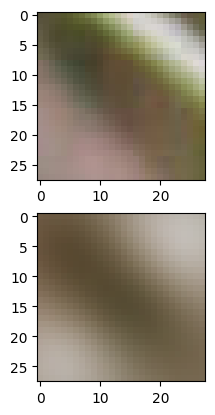

In [19]:
hp = defaultDict(28)
hp['patchStep'] = 8
hp['lr'] = 0.0005
hp['epochs'] = 300
AEt = AEtrainer(hp)


patches, r= splitPatches((28,28),8)(im, im[:,:,0])
print(patches.shape)
m,n = patches.shape[0:2]
patcheslist = patches.reshape(m*n, 28,28,3)
plt.imshow(patcheslist[81])

AEt(patcheslist)
AEt.show(patcheslist[81:])


torch.Size([2646, 7])


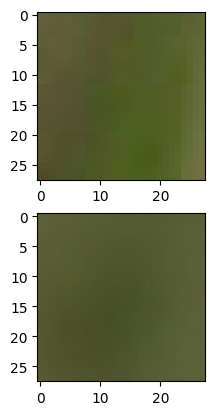

In [22]:
splt = splitPatches((28,28),28)
patches, r= splt (im, im[:,:,0])
m,n = patches.shape[0:2]

patcheslist = patches.reshape(m*n, 28,28,3)
AEt.show(patcheslist[400:])

lt = AEt.latent(patcheslist)
print(lt.size())

lt = lt.detach().numpy()
lt = lt.reshape(m,n, -1)
np.save('./amanita_ae_d_28_28_lt', lt)

rec = AEt.rec(patcheslist).detach().numpy()
rec = rec.reshape(m,n,28,28,3)
np.save('./amanita_ae_d_28_28_rec', rec)

In [23]:
hist = histogram(patcheslist)
print(hist.shape)
hist = hist.reshape(m,n,-1)
np.save('./amanita_hist_28_28_rec', hist)

(2646, 32)
